### Home Credit Default Risk 

In [83]:
import numpy as np
import pandas as pd 
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

###### Plot roc curve funtion

In [82]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

#### Data acquire

In [272]:
train = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_train.csv')

In [273]:
train_new = train.copy()

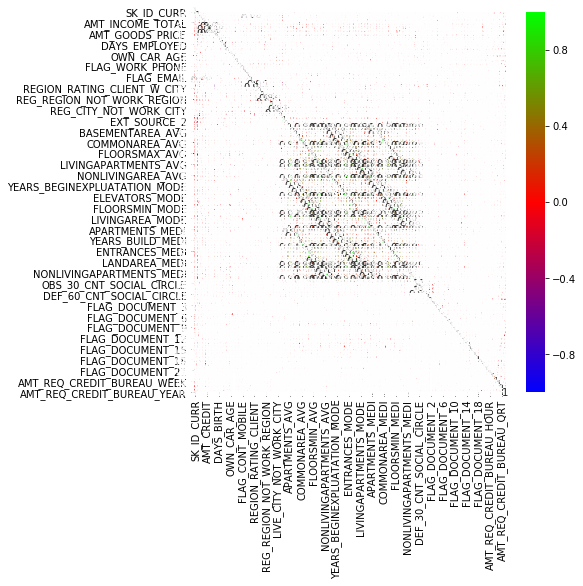

In [3]:
plt.figure(figsize=(7,7))
corr = train.corr()
sns.heatmap(corr,annot=True,cmap=plt.cm.brg)
plt.show()


In [4]:
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Data preparation

#### Target 

In [5]:
Y = train.TARGET

###### This is the clear case of LABEL UNBALANCE

In [6]:
Y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

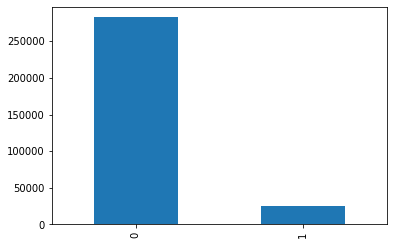

In [7]:
Y.value_counts().plot.bar()

In [8]:
Y.value_counts().index

Int64Index([0, 1], dtype='int64')

In [9]:
df = pd.DataFrame({'labels':Y.value_counts().index,
                  'values': Y.value_counts().values}
                 )

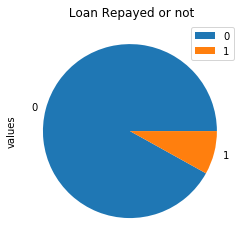

In [10]:
df.plot.pie(y='values',title =' Loan Repayed or not')

The frequency of feature 0 is very high as compare to feature 1

##### Remove ID feature

In [11]:
train_cropped = train.drop(columns=['SK_ID_CURR','TARGET'])

In [139]:
train_cropped.isna().count()

NAME_CONTRACT_TYPE            307511
CODE_GENDER                   307511
FLAG_OWN_CAR                  307511
FLAG_OWN_REALTY               307511
CNT_CHILDREN                  307511
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY     307511
AMT_REQ_CREDIT_BUREAU_WEEK    307511
AMT_REQ_CREDIT_BUREAU_MON     307511
AMT_REQ_CREDIT_BUREAU_QRT     307511
AMT_REQ_CREDIT_BUREAU_YEAR    307511
Length: 120, dtype: int64

##### Check the missing values

In [12]:
missing_values = pd.DataFrame(train_cropped.isna().sum().sort_values(ascending=False)/len(train_cropped))

In [13]:
missing_values.columns = ['Missing_values']
missing_values

,Missing_values
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
...,...
REG_CITY_NOT_WORK_CITY,0.000000
REG_CITY_NOT_LIVE_CITY,0.000000
LIVE_REGION_NOT_WORK_REGION,0.000000
REG_REGION_NOT_LIVE_REGION,0.000000


In [142]:
missing_values

,Missing_values
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
...,...
REG_CITY_NOT_WORK_CITY,0.000000
REG_CITY_NOT_LIVE_CITY,0.000000
LIVE_REGION_NOT_WORK_REGION,0.000000
REG_REGION_NOT_LIVE_REGION,0.000000


In [14]:
train_cropped

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


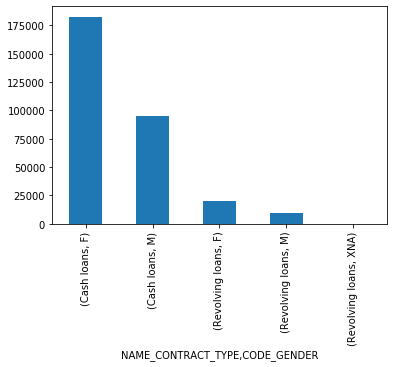

In [15]:
train_cropped.groupby(['NAME_CONTRACT_TYPE'])['CODE_GENDER'].value_counts().plot.bar()

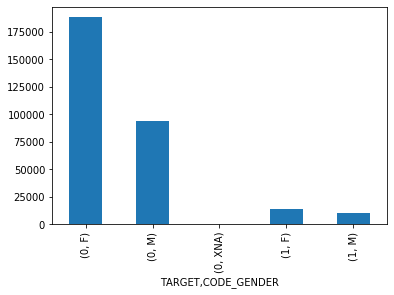

In [16]:
train_cropped.groupby([Y])['CODE_GENDER'].value_counts().plot.bar()

In [17]:
missing_values.Missing_values.value_counts().values

array([53,  6,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [18]:
missing_values.Missing_values.value_counts().index

Float64Index([                   0.0,    0.13501630835970097,
               0.0033202064316398437,     0.6987229725115525,
                  0.5019332641759157,     0.6649778381911542,
                   0.503487680115508,      0.532959796560123,
                  0.6784862980511266,    0.48781019215572774,
                  0.5517916432257708,     0.6835495315614726,
                  0.6943296337366793,     0.5937673774271489,
                  0.4976082156410665,     0.5074972927797705,
                  0.5851595552679416,  0.0009040327012692228,
                  0.6599081008484249, 3.9022994299390916e-05,
              3.2519161916159095e-06,     0.5638107254699832,
                  0.4826851722377411,     0.6838617155158677,
               6.503832383231819e-06,      0.508407829313423,
                 0.47398304450897694,    0.19825307062186392,
                    0.50176091261776,   0.004201475719567756,
                 0.31345545362604915,  0.0021462646864665006],
       

In [19]:
df3 = pd.DataFrame({'lables':missing_values.Missing_values.value_counts().index,
                   'values':missing_values.Missing_values.value_counts().values})

In [20]:
df3.iplot(kind='pie',labels='lables',values = 'values',title = 'Missing values',hole = 0.2)

In [21]:
train_cropped.dtypes

NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 120, dtype: object

##### Let's analyis categorical and numerical value first 

In [22]:
train_cropped

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def analysis(df):
    categorical=[]
    numerical= []
    for col in df:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return  categorical,numerical

In [ ]:
# c,n = analysis(train_new)

In [ ]:
# Impute_numerical(train_new,n)

In [ ]:
encoding(train_cropped)

In [24]:
categorical, numerical = analysis(train_cropped)

In [25]:
categorical

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [26]:
numerical

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

In [27]:
train_cropped.NAME_CONTRACT_TYPE.value_counts().sort_values(ascending=False).index[0]

'Cash loans'

###### Fill MISSING VALUES IN CATEGORICAL COL

In [28]:
def Impute_categorical(df,col):
    for i in col:
        most_frequent = df[i].value_counts().sort_values(ascending=False).index[0]
        #Fill the missing categorical values with mosst frequent
        
        df[i] = df[i].fillna(most_frequent)

In [29]:
Impute_categorical(train_cropped,categorical)

##### Fill Missing values in Numerical col

In [30]:
def Impute_numerical(df,col):
    for i in col:
        df[i] = df[i].fillna(df[i].mean())

In [31]:
Impute_numerical(train_cropped,numerical)

In [32]:
len(train_cropped.FLAG_OWN_REALTY.unique())

2

##### Encoding

In [333]:
def encoding(df):
    lb = LabelEncoder()
    for i in df:
        if df[i].dtype == 'object':
            if len(df[i].unique()) <=2:
                df[i] =lb.fit_transform(df[i])
            else:
                df[i]= pd.get_dummies(df[i])

In [334]:
encoding(train_cropped)

In [35]:
train_cropped

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,0,1,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,1,0,1,1,0,67500.0,135000.0,6750.0,135000.0,0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,0,1,0,1,0,135000.0,312682.5,29686.5,297000.0,0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307507,0,1,0,1,0,72000.0,269550.0,12001.5,225000.0,0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307508,0,1,0,1,0,153000.0,677664.0,29979.0,585000.0,0,...,0,0,0,0,1.000000,0.000,0.000000,1.000000,0.000000,1.000000
307509,0,1,0,1,0,171000.0,370107.0,20205.0,319500.0,0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


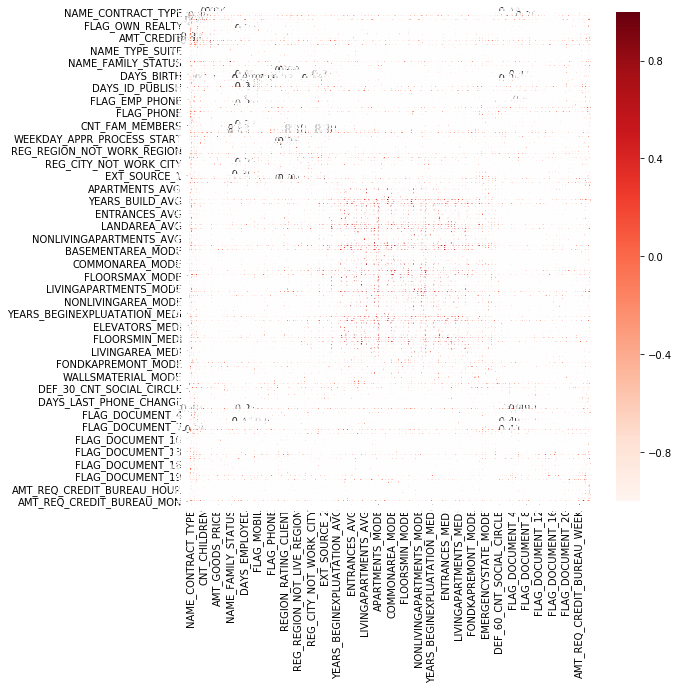

In [36]:
plt.figure(figsize=(9,9))
cor = train_cropped.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

##### Perform Feature Selection

###### Use PCA

In [37]:
from sklearn.decomposition import PCA

In [38]:
min_scaler = MinMaxScaler()
train_cropped_rescaled = min_scaler.fit_transform(train_cropped)
pca = PCA().fit(train_cropped_rescaled)


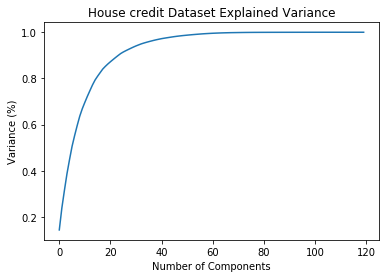

In [39]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('House credit Dataset Explained Variance')
plt.show()

##### Recursive Feature Elimination

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [41]:
lr = LogisticRegression(C=1.0,class_weight={0:0.5,1:0.95},random_state=101)
rfe_selector = RFE(estimator=lr,verbose=5,n_features_to_select=100,step=10)
rfe_selector = rfe_selector.fit(train_cropped,Y)

Fitting estimator with 120 features.


/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Fitting estimator with 110 features.


/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [42]:
rfe_selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
        True,  True,  True])

In [43]:
rfe_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 2,
       1, 2, 3, 3, 2, 1, 2, 1, 1, 1])

In [44]:
rfe_feature = train_cropped.loc[:,rfe_selector.get_support()].columns.tolist()
print(rfe_feature)
print()
print(str(len(rfe_feature)), 'selected features')

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LI

#### According to RFE these abive features are important

In [45]:
subset = train_cropped.columns.difference(rfe_feature)

In [46]:
len(subset)

20

In [47]:
new_train = train_cropped.drop(columns=subset)

##### Let's try with random forest 

In [48]:
clf_rf = RandomForestClassifier(n_estimators=100,class_weight={0:0.10,1:0.90})
clf_rf.fit(train_cropped,Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [49]:
X_, Y_ = (list(i) for i in zip(*sorted(zip(clf_rf.feature_importances_, train_cropped.columns), 
                                                            reverse = False)))

In [50]:
trace2 = go.Bar(
    x=X_ ,
    y=Y_,
    marker=dict(
        color=X_,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)
layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

##### Let's fit the model 

In [542]:
from sklearn.model_selection import StratifiedKFold , train_test_split
from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='ticks', context='talk')
# plt.style.use('dark_background')

In [52]:
Y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [53]:
kfold = StratifiedKFold(n_splits=4)

##### Normalization

In [55]:
new_train_rescaled = min_scaler.fit_transform(new_train)

##### Cross-validation

In [58]:
from xgboost import XGBClassifier

random_state=3
classifiers = []

# classifiers.append(SVC(random_state=random_state,class_weight={0:0.05,1:0.95}))
classifiers.append(DecisionTreeClassifier(random_state=random_state,class_weight={0:0.05,1:0.95}))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state,class_weight={0:0.05,1:0.95}), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,class_weight={0:0.05,1:0.95}))
# classifiers.append(ExtraTreesClassifier(random_state=random_state,class_weight={0:0.05,1:0.95}))
# classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state,class_weight={0:0.05,1:0.95}))
# classifiers.append(LinearDiscriminantAnalysis())
# classifiers.append(XGBClassifier(random_state=random_state,class_weight={0:0.05,1:0.95}))

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-pac

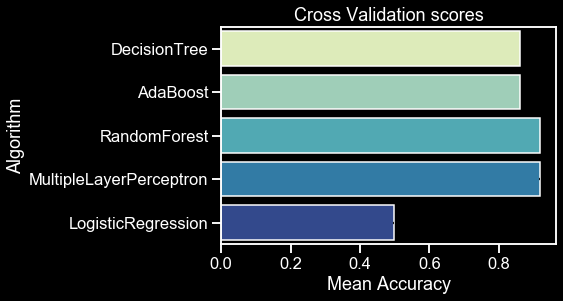

In [57]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, new_train_rescaled, y=Y, scoring='accuracy', cv=kfold))

cv_means = []
cv_std   = []
for cv_result in cv_results:
    cv_means.append( cv_result.mean() )
    cv_std.append(   cv_result.std()  )
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CorssValerrors':cv_std,
                       'Algorithm':['DecisionTree','AdaBoost','RandomForest',
                                    'MultipleLayerPerceptron','LogisticRegression',]})

g = sns.barplot('CrossValMeans','Algorithm', data=cv_res, palette='YlGnBu', orient='h', **{'xerr':cv_std})
g = g.set(title='Cross Validation scores',xlabel='Mean Accuracy')

#### RadomForest

accuracy: 0.8030827764499293
roc_auc: 0.7341236759477722


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



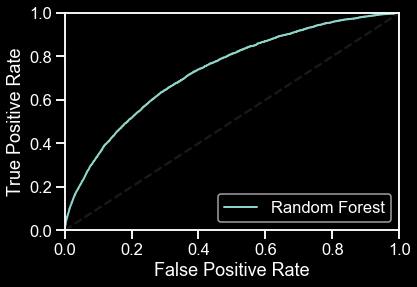

accuracy: 0.8027218627036519
roc_auc: 0.7372267207274594


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



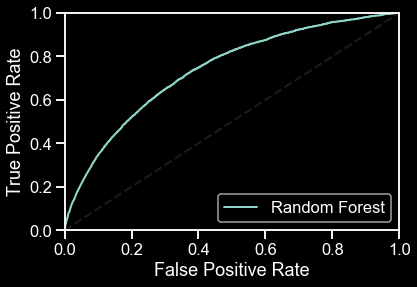

accuracy: 0.8050795096094436
roc_auc: 0.7290499367479248


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



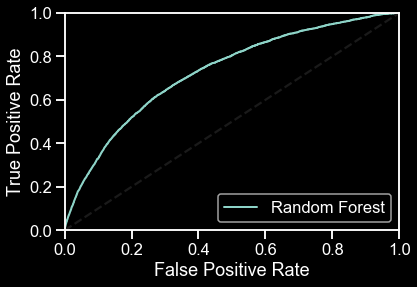

accuracy: 0.8059737894702611
roc_auc: 0.7329590238306275


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



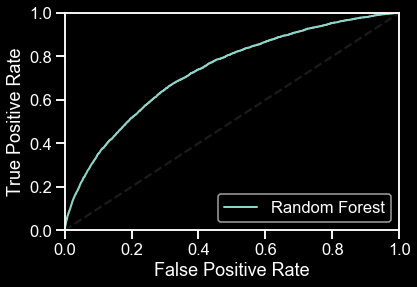

accuracy: 0.8089493024617086
roc_auc: 0.735050758853015


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



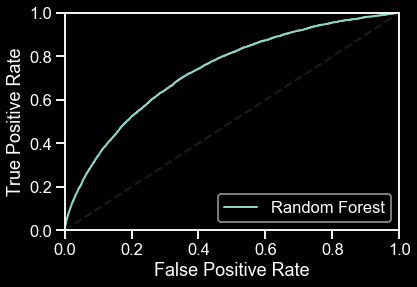

In [190]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

new_train_rescaled = min_scaler.fit_transform(new_train)
# print(new_train_rescaled)
for train_index, test_index in skfolds.split(new_train_rescaled,Y):
#     print(test_index)
#     print(train_index)
    clone_clf_rf = clone(RandomForestClassifier(max_depth=10,class_weight={0:0.10,1:0.90},n_estimators=100))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_rf.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_rf.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_rf.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_forest, tpr_forest, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
    plt.legend(loc='bottom right')
    plt.title
    plt.show()
    
    

##### XGboost

accuracy: 0.9197274929678227
roc_auc: 0.7497941460612344


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



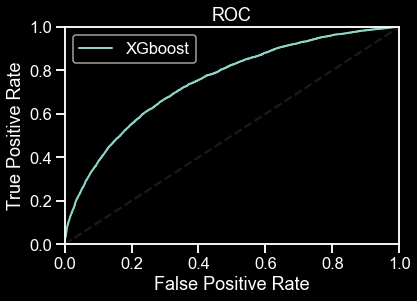

accuracy: 0.919563591427921
roc_auc: 0.7505643257868133


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



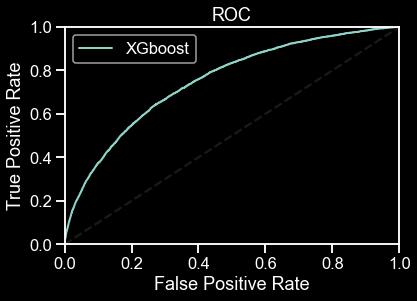

accuracy: 0.9192546583850931
roc_auc: 0.7441603098869867


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



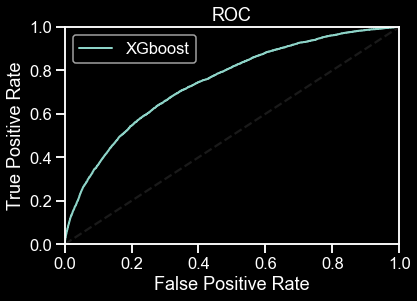

accuracy: 0.9192871776527592
roc_auc: 0.751233771266296


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



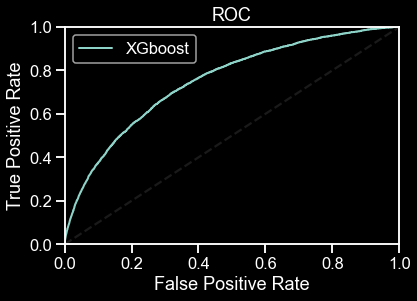

accuracy: 0.9195961106955871
roc_auc: 0.7524449646561964


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



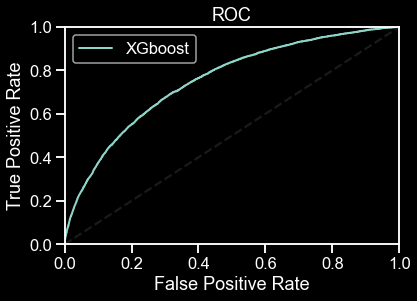

In [193]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

new_train_rescaled = min_scaler.fit_transform(new_train)
for train_index, test_index in skfolds.split(new_train_rescaled,Y):
    clone_clf_xgb = clone(XGBClassifier(max_depth=10))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_xgb.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_xgb.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_xgb.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_xg, tpr_xg, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_xg,tpr_xg,"XGboost")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

##### Logistic Regression

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.755491602035673
roc_auc: 0.7389440042588971


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



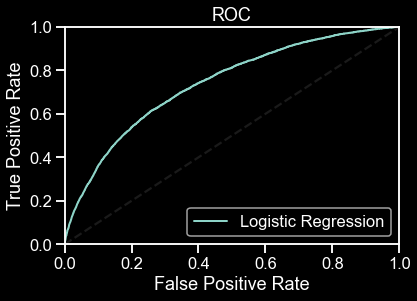

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7521056225813795
roc_auc: 0.7392293554750596


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



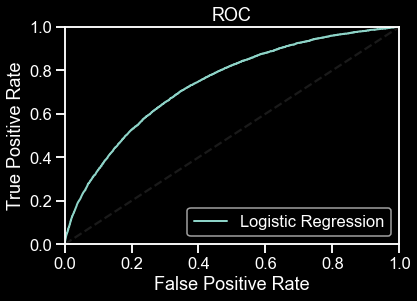

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7521869207505447
roc_auc: 0.7353127694487552


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



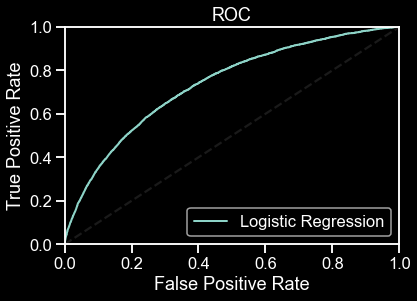

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7579753503951091
roc_auc: 0.7416618845315515


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



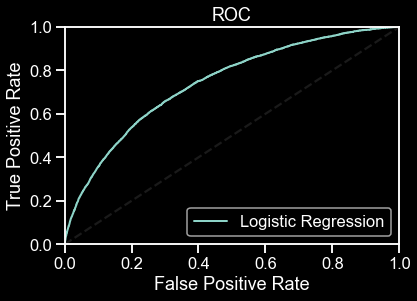

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.754056778641345
roc_auc: 0.7424127585637089


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



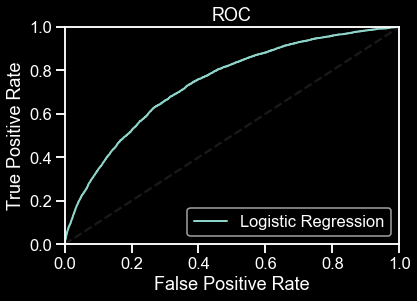

In [194]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

new_train_rescaled = min_scaler.fit_transform(new_train)
# print(new_train_rescaled)
for train_index, test_index in skfolds.split(new_train_rescaled,Y):
#     print(test_index)
#     print(train_index)
    clone_clf_lr = clone(LogisticRegression(C=1.0,class_weight={0:0.10,1:0.90}))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_lr.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_lr.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_lr.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_lr, tpr_lr, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_lr,tpr_lr,"Logistic Regression")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

##### SGDClassifier

accuracy: 0.7977334438970457
roc_auc: 0.7322202158895208


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



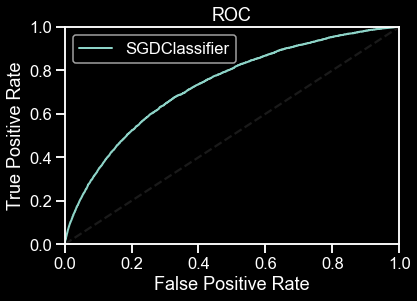

accuracy: 0.7849338232902995
roc_auc: 0.7332587998900844


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



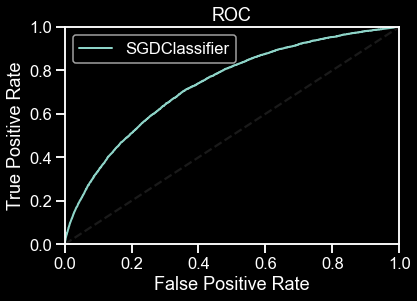

accuracy: 0.7570973301681246
roc_auc: 0.7295352733652609


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



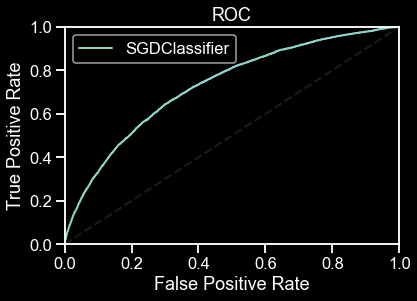

accuracy: 0.7845598517121395
roc_auc: 0.7395258540864816


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



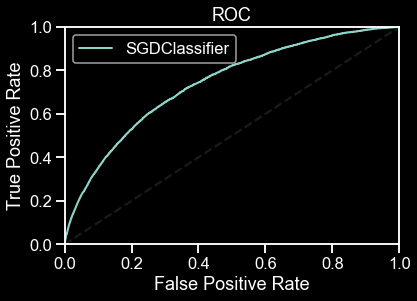

accuracy: 0.7775194302624305
roc_auc: 0.7364786930876714


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



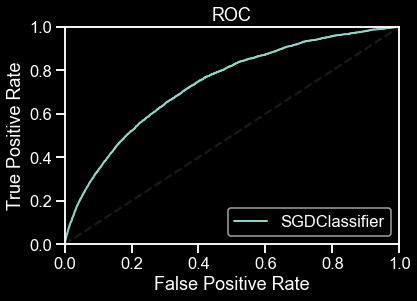

In [196]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(new_train_rescaled,Y):
    clone_clf_sgd = clone(SGDClassifier(class_weight={0:0.10,1:0.90},early_stopping=True,
                                    random_state=42,loss='modified_huber',max_iter=1000))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_sgd.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_sgd.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_sgd.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"SGDClassifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

##### GridSearch

###### XGBoost

In [70]:
XGB = XGBClassifier(random_state=0)

xgb_param_grid={'colsample_bylevel':[0.9],
                'colsample_bytree' :[0.8],
                'gamma'            :[0.99],
                'max_depth'        :[4],
                'min_child_weight' :[1],
                'n_estimators'     :[10],
                'nthread'          :[4],
                'silent'           :[True]}

gsXGB = GridSearchCV(XGB, param_grid=xgb_param_grid, cv=5, scoring='accuracy', verbose=1)
gsXGB.fit(new_train_rescaled,Y)
XGBC_best = gsXGB.best_estimator_

gsXGB.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


0.9192711805431351

##### MLPClassifier

In [71]:
parameters = {'solver':['adam'], 'max_iter':[800], 'alpha':10.0**-np.arange(1,10), 'hidden_layer_sizes':[40,20,10], 'random_state':[0,1] }
gsMLPC=GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

gsMLPC.fit(new_train_rescaled,Y)
MLPC_best = gsMLPC.best_estimator_

gsMLPC.best_score_

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



0.9193297150345842

#### Logistic Regression

In [143]:
LR = LogisticRegression(class_weight={0:0.5,1:0.95})

lr_param_grid = {'C':[0.0001,0.1,1.0,10.0]}

gslr = GridSearchCV(LR, param_grid=lr_param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1)
gslr.fit(new_train_rescaled,Y)
LR_best = gslr.best_estimator_

gslr.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.7min finished
/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.501972287170215

##### RandomForest

In [148]:
RFC = RandomForestClassifier(random_state=0)

rf_param_grid = {'max_depth'        :[10],
                 'max_features'     :[10],
                 'min_samples_split':[10],
                 'bootstrap'        :[False],
                 'n_estimators'     :[100],
                 'criterion'        :['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(new_train_rescaled,Y)
RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.6min finished


0.9192711805431351

In [144]:
gslr.best_estimator_

LogisticRegression(C=10.0, class_weight={0: 0.05, 1: 0.95}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Voting Classifier

In [168]:
voting_classifier = VotingClassifier(estimators=[('lr',gslr),('MLP',gsMLPC),('RF',gsRFC),('xgb',gsXGB)],voting='soft')

In [ ]:
# for clf in (gslr,gsMLPC,gsRFC,gsXGB,voting_classifier):
#     clf.fit(new_train_rescaled,Y)
#     score = clf.score(new_train_rescaled,Y)
# #     y_pred = clf.predict(X_test)
#     print('#####################')
#     print(clf.__class__.__name__, score)
    
#     print('#######################')
# #     print(clf.__class__.__name__ , accuracy_score(y_pred,Y_test))
    
#     print("########################")
# #     print(clf.__class__.__name__ , confusion_matrix(y_pred,Y_test))
    
#     print("#########################")
#     print(clf.__class__.__name__, roc_auc_score(y_pred,Y_test))
    

In [171]:
new_train_rescaled.shape

(307511, 100)

In [169]:
voting_classifier.fit(new_train_rescaled,Y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  4.1min finished
/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.2s finished


VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=5,
                                           error_score='raise-deprecating',
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight={0: 0.05,
                                                                                      1: 0.95},
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                   

In [ ]:
# lr = LogisticRegression(C=1.0,class_weight ={0:0.5,1:0.95})

In [ ]:
# lr.fit(new_train_rescaled,Y)

#### Test data acquire

In [172]:
test = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_test.csv',low_memory=False)

In [173]:
test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
submit = test[['SK_ID_CURR']]

In [175]:
test_trimmed= test.drop(columns='SK_ID_CURR')

In [176]:
categorical_test, numerical_test =analysis(test_trimmed)

In [177]:
Impute_categorical(test_trimmed,categorical_test)

In [178]:
Impute_numerical(test_trimmed,numerical_test)

In [179]:
pd.DataFrame(test_trimmed.isna().sum())

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0


In [180]:
encoding(test_trimmed)

In [181]:
test_trimmed.drop(columns=subset,inplace=True)

In [182]:
test_trimmed.shape

(48744, 100)

In [183]:
test_trimmed_rescaled = min_scaler.fit_transform(test_trimmed)

In [116]:
test_trimmed_rescaled.shape

(48744, 100)

In [185]:
voting_classifier.predict_proba(test_trimmed_rescaled)[:,1]

array([0.27640989, 0.30703846, 0.12579704, ..., 0.13189379, 0.2221104 ,
       0.33027776])

In [186]:
submit['TARGET'] = voting_classifier.predict_proba(test_trimmed_rescaled)[:,1]

###### Logistic Regression

In [145]:
submit['TARGET']=gslr.predict_proba(test_trimmed_rescaled)[:,1]

##### MLPclassifier

In [122]:
submit['TARGET']= gsMLPC.predict_proba(test_trimmed_rescaled)[:,1]

##### XGBoost

In [140]:
submit['TARGET']= gsXGB.predict_proba(test_trimmed_rescaled)[:,1]

##### RandomForest

In [149]:
submit['TARGET']= gsRFC.predict_proba(test_trimmed_rescaled)[:,1]

###### Cross-validationXGB

In [197]:
clone_clf_xgb.fit(new_train_rescaled,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [200]:
clone_clf_xgb.predict_proba(test_trimmed_rescaled)[:,1]

array([0.05230582, 0.08033826, 0.01787215, ..., 0.06263991, 0.03355365,
       0.14631002], dtype=float32)

In [201]:
submit['TARGET'] = clone_clf_xgb.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_xgb.csv',index= False)

##### Cross-validation RandomForest

In [202]:
clone_clf_rf.fit(new_train_rescaled,Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [203]:
clone_clf_rf.predict_proba(test_trimmed_rescaled)[:,1]

array([0.33684825, 0.38322134, 0.18818361, ..., 0.26729431, 0.30664803,
       0.52315834])

In [204]:
submit['TARGET'] = clone_clf_rf.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_rf.csv',index= False)

#### Cross-validation LogisticRegression

In [205]:
clone_clf_lr.fit(new_train_rescaled,Y) 

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [207]:
clone_clf_lr.predict_proba(test_trimmed_rescaled)[:,1]

array([0.49551912, 0.59929705, 0.19121879, ..., 0.34232935, 0.35956215,
       0.67845638])

In [208]:
submit['TARGET'] = clone_clf_lr.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_lr.csv',index= False)

##### Cross-validation SGDClassifier

In [209]:
clone_clf_sgd.fit(new_train_rescaled,Y) 

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 0.1, 1: 0.9},
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [210]:
clone_clf_sgd.predict_proba(test_trimmed_rescaled)[:,1]

array([0.4152007 , 0.56225402, 0.13645732, ..., 0.3699454 , 0.50824352,
       0.64904913])

In [211]:
submit['TARGET'] = clone_clf_sgd.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_sgd.csv',index= False)

#### VotingClassifer

#### USING ALL FEATURES

In [151]:
train_cropped_scaled = min_scaler.fit_transform(train_cropped)

In [166]:
lr_new = LogisticRegression(C=10.0,class_weight='balanced')

In [167]:
lr_new.fit(train_cropped_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=10.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [163]:
test_trimmed_rescaled = min_scaler.fit_transform(test_trimmed)

In [ ]:
voting_classifier.predict_proba(test_trimmed_rescaled)[:,1]

In [164]:
submit['TARGET']= lr_new.predict_proba(test_trimmed_rescaled)[:,1]

In [ ]:
# submit['TARGET'] =lr.predict_proba(test_trimmed_rescaled)[:,1]

In [188]:
submit

,SK_ID_CURR,TARGET
0,100001,0.276410
1,100005,0.307038
2,100013,0.125797
3,100028,0.165332
4,100038,0.262326
...,...,...
48739,456221,0.228483
48740,456222,0.262597
48741,456223,0.131894
48742,456224,0.222110


In [189]:
submit.to_csv('/Users/nandrajog/Desktop/01-feb-voting.csv',index=False)

###### Let's Try with different combination of classifiers with diff feature engg technique

In [274]:
train_new.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
Y_new = train_new.TARGET

In [270]:
# submit = train_new[['SK_ID_CURR']]

In [276]:
train_new.drop(columns=['SK_ID_CURR','TARGET'],inplace=True)

In [277]:
encoding(train_new)

In [278]:
def Imputation_mean_new(df):
    for col in df:
        df[col] = df[col].fillna(df[col].mean())

In [279]:
Imputation_mean_new(train_new)

In [280]:
train_new.isna().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 120, dtype: int64

In [326]:
# clf_rf = RandomForestClassifier(n_estimators=500,class_weight={0:0.10,1:0.90},max_depth=8,random_state=True)
clf_lr = LogisticRegression(C=10.0)
# clf_sgd = SGDClassifier(max_iter=1000,loss='modified_huber',class_weight={0:0.10,1:0.90})

In [296]:
v_c = VotingClassifier(estimators=[('lr',clf_lr),('sgd',clf_sgd),('RF',clf_rf)],voting='soft')

In [297]:
train_new.shape

(307511, 120)

In [298]:
train_new_rescaled = min_scaler.fit_transform(train_new)

In [327]:
clf_lr.fit(train_new_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [328]:
test = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_test.csv',low_memory=False)
test_new = test.copy()
submit = test_new[['SK_ID_CURR']]
test_trimmed_new= test_new.drop(columns='SK_ID_CURR')
# categorical_test, numerical_test =analysis(test_trimmed)
# Impute_categorical(test_trimmed,categorical_test)
# Impute_numerical(test_trimmed,numerical_test)
encoding(test_trimmed_new)
Imputation_mean_new(test_trimmed_new)
test_trimmed_new_rescale = min_scaler.fit_transform(test_trimmed_new)


In [329]:
clf_lr.predict_proba(test_trimmed_new_rescale)[:,1]

array([0.11275465, 0.14731395, 0.01434815, ..., 0.00683995, 0.04605446,
       0.11814206])

In [330]:
submit['TARGET'] = clf_lr.predict_proba(test_trimmed_new_rescale)[:,1]

In [331]:
submit.to_csv('/Users/nandrajog/Desktop/lr-2-2-20-3.csv',index=False)

In [332]:
submit

,SK_ID_CURR,TARGET
0,100001,0.112755
1,100005,0.147314
2,100013,0.014348
3,100028,0.023156
4,100038,0.058446
...,...,...
48739,456221,0.085973
48740,456222,0.081827
48741,456223,0.006840
48742,456224,0.046054


In [219]:
v_c.predict_proba(test_trimmed_rescaled)[:,1]

array([0.46561792, 0.53970713, 0.1903648 , ..., 0.27507614, 0.36300468,
       0.60233875])

In [220]:
submit['TARGET'] = v_c.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/V_C.csv',index= False)

##### Let's Try with different combination of classifiers with ALL features

In [222]:
train_cropped_rescaled.shape

(307511, 120)

In [223]:
v_c.fit(train_cropped_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10.0,
                                                 class_weight={0: 0.1, 1: 0.9},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight={0: 0.1, 1...
                                                

In [224]:
test = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_test.csv',low_memory=False)
submit = test[['SK_ID_CURR']]
test_trimmed= test.drop(columns='SK_ID_CURR')
categorical_test, numerical_test =analysis(test_trimmed)
Impute_categorical(test_trimmed,categorical_test)
Impute_numerical(test_trimmed,numerical_test)
encoding(test_trimmed)

In [225]:
test_trimmed.shape

(48744, 120)

In [227]:
test_trimmed_rescaled = min_scaler.fit_transform(test_trimmed)

In [228]:
v_c.predict_proba(test_trimmed_rescaled)[:,1]

array([0.45595919, 0.53032284, 0.17830013, ..., 0.27234489, 0.34368109,
       0.59096812])

In [229]:
submit['TARGET'] = v_c.predict_proba(test_trimmed_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/V_C2.csv',index= False)

### Let's try a different approach

In [429]:
train = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_train.csv')
test = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_test.csv',low_memory=False)

In [430]:
train_data = train.copy()
test_data = test.copy()

In [431]:
train_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
train_data.drop(columns=['SK_ID_CURR','TARGET'],inplace=True)
submit = test_data[['SK_ID_CURR']]
test_data.drop(columns = ['SK_ID_CURR'],inplace=True)

In [433]:
def binary_encoding(df):
    lb = LabelEncoder()
    for i in df:
        if df[i].dtype == 'object':
            if len(df[i].unique()) <=2:
                lb.fit(df[i])
                df[i] =lb.fit_transform(df[i])


In [434]:
binary_encoding(train_data)
binary_encoding(test_data)

In [435]:
train_data.shape
test_data.shape

(48744, 120)

In [436]:
pd.get_dummies(train_data)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,...,0,1,0,0,0,0,0,0,1,0
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,...,0,0,0,0,0,0,1,0,1,0
307507,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,...,0,0,0,0,0,0,1,0,1,0
307508,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,...,0,0,0,0,0,1,0,0,1,0
307509,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,...,0,0,0,0,0,0,1,0,1,0


In [437]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [438]:
Imputation_mean_new(train_data)
Imputation_mean_new(test_data)

In [439]:
print(train_data.shape)
print(test_data.shape)

(307511, 241)
(48744, 237)


##### Column inconsistency Let's remove this issue

In [440]:
train_data_new, test_data_new = train_data.align(test_data,join='inner',axis=1)

###### Normalization

In [441]:
train_data_new_rescaled = min_scaler.fit_transform(train_data_new)

In [443]:
test_data_new_rescaled = min_scaler.fit_transform(test_data_new)

#### LRegression

In [442]:
gslr.fit(train_data_new_rescaled,Y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  5.6min finished
/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0,
                                          class_weight={0: 0.05, 1: 0.95},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4, param_grid={'C': [0.0001, 0.1, 1.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [445]:
gslr.predict_proba(test_data_new_rescaled)[:,1]

array([0.56421458, 0.85413618, 0.44226436, ..., 0.19754112, 0.5027584 ,
       0.69122437])

In [446]:
submit['TARGET'] = gslr.predict_proba(test_data_new_rescaled)[:,1]

In [447]:
submit.to_csv('/Users/nandrajog/Desktop/gslr-02.csv',index=False)

#### RandomForest

In [448]:
gsRFC.fit(train_data_new_rescaled,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'boot

In [449]:
submit['TARGET'] = gsRFC.predict_proba(test_data_new_rescaled)[:,1]

In [450]:
submit.to_csv('/Users/nandrajog/Desktop/gsRFC-02.csv',index=False)

#### xgboost

In [451]:
gsXGB.fit(train_data_new_rescaled,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...a=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bylevel': [0.9], 'colsample_bytree': [0.8],
                         'gamma': [0.99], 'max_depth': [4],
                         'mi

In [452]:
gsXGB.predict_proba(test_data_new_rescaled)[:,1]

array([0.22447497, 0.24481027, 0.19831356, ..., 0.22508697, 0.21101856,
       0.24274132], dtype=float32)

In [453]:
submit['TARGET'] = gsXGB.predict_proba(test_data_new_rescaled)[:,1]

In [454]:
submit.to_csv('/Users/nandrajog/Desktop/gsXGB-02.csv',index=False)

In [456]:
train_data_new_rescaled.shape

(307511, 236)

#### Cross-validation with LR

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.755491602035673
roc_auc: 0.7389440042588971


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



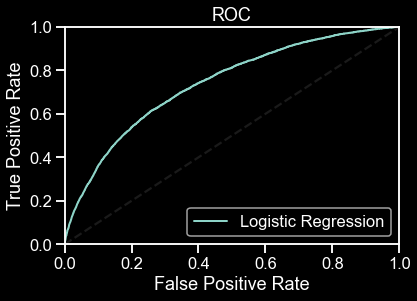

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7521056225813795
roc_auc: 0.7392293554750596


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



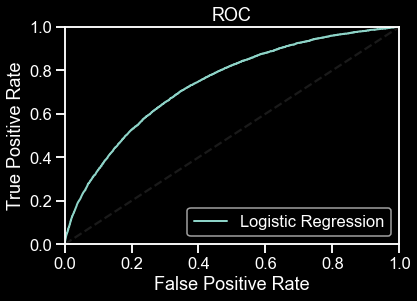

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7521869207505447
roc_auc: 0.7353127694487552


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



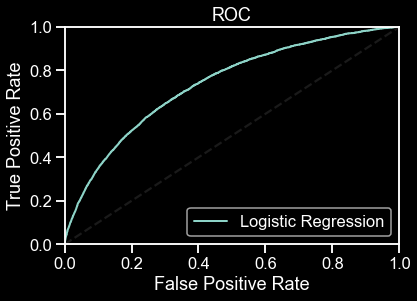

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7579753503951091
roc_auc: 0.7416618845315515


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



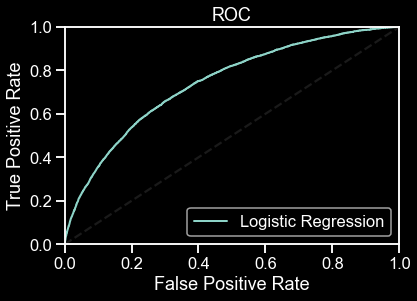

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.754056778641345
roc_auc: 0.7424127585637089


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



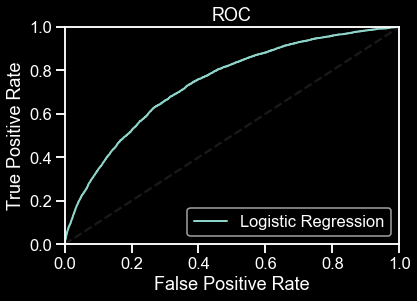

In [455]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)
# print(new_train_rescaled)
for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
#     print(test_index)
#     print(train_index)
    clone_clf_lr = clone(LogisticRegression(C=1.0,class_weight={0:0.10,1:0.90}))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_lr.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_lr.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_lr.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_lr, tpr_lr, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_lr,tpr_lr,"Logistic Regression")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [458]:
clone_clf_lr.fit(train_data_new_rescaled,Y) 

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [460]:
clone_clf_lr.predict_proba(test_data_new_rescaled)[:,1]

array([0.35334678, 0.74302073, 0.35584004, ..., 0.32678079, 0.32723098,
       0.60391502])

In [461]:
submit['TARGET'] = clone_clf_lr.predict_proba(test_data_new_rescaled)[:,1]

In [462]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_lr-02.csv',index=False)

##### Cross-validation with XGBOOST

accuracy: 0.9197274929678227
roc_auc: 0.7497941460612344


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



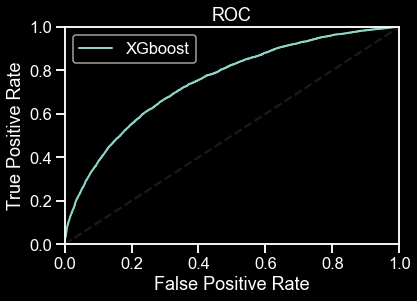

accuracy: 0.919563591427921
roc_auc: 0.7505643257868133


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



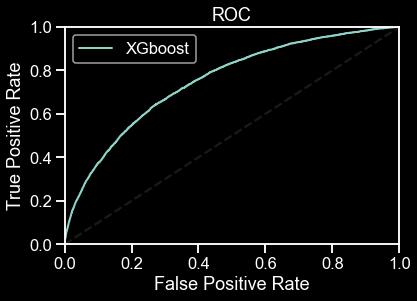

accuracy: 0.9192546583850931
roc_auc: 0.7441603098869867


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



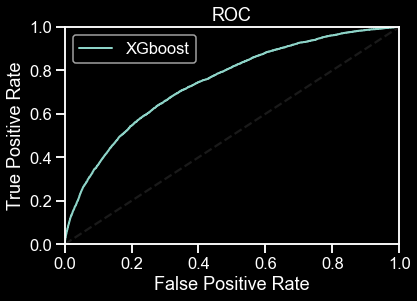

accuracy: 0.9192871776527592
roc_auc: 0.751233771266296


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



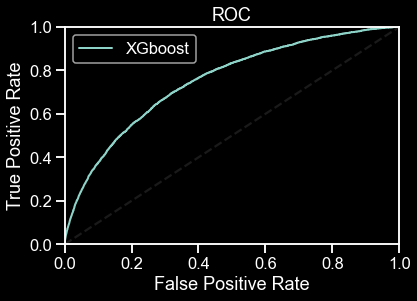

accuracy: 0.9195961106955871
roc_auc: 0.7524449646561964


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



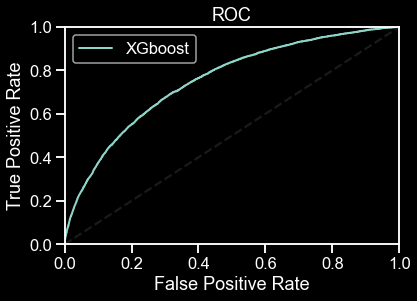

In [463]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)
for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
    clone_clf_xgb = clone(XGBClassifier(max_depth=10))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_xgb.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_xgb.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_xgb.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_xg, tpr_xg, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_xg,tpr_xg,"XGboost")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [466]:
clone_clf_xgb.fit(train_data_new_rescaled,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [470]:
clone_clf_xgb.predict_proba(test_data_new_rescaled)

array([[0.96665365, 0.03334635],
       [0.86449856, 0.13550143],
       [0.98266745, 0.01733254],
       ...,
       [0.87714756, 0.12285247],
       [0.9560782 , 0.04392185],
       [0.8153711 , 0.18462889]], dtype=float32)

In [468]:
submit['TARGET'] =clone_clf_xgb.predict_proba(test_data_new_rescaled)

In [469]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_xgb-02.csv',index=False)

In [471]:
train_data_new_rescaled.shape

(307511, 236)

##### Cross-validation with RF

accuracy: 0.805570459977562
roc_auc: 0.7356644732021174


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



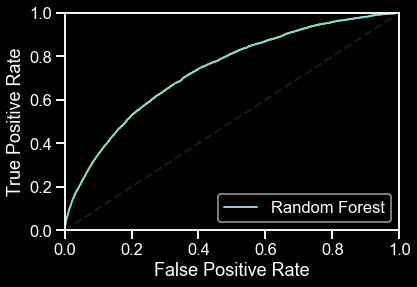

accuracy: 0.8012259763910117
roc_auc: 0.7379248563458012


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



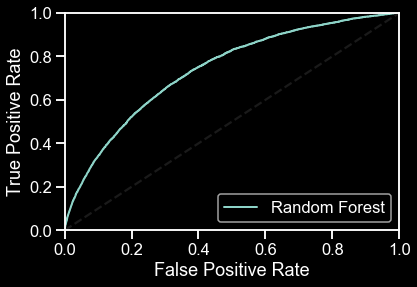

accuracy: 0.806282722513089
roc_auc: 0.7302047420006267


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



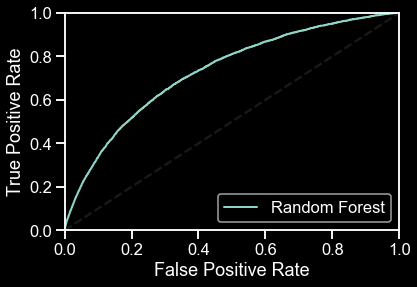

accuracy: 0.8057786738642646
roc_auc: 0.735630275789593


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



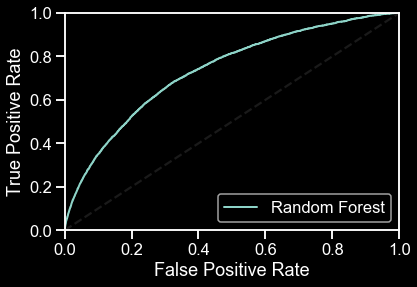

accuracy: 0.8081363207700563
roc_auc: 0.7365769096554172


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



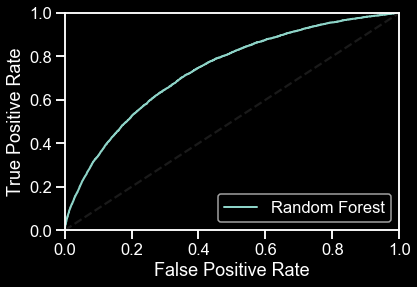

In [472]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)
# print(new_train_rescaled)
for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
#     print(test_index)
#     print(train_index)
    clone_clf_rf = clone(RandomForestClassifier(max_depth=10,class_weight={0:0.10,1:0.90},n_estimators=500))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_rf.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_rf.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_rf.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_forest, tpr_forest, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
    plt.legend(loc='bottom right')
    plt.title
    plt.show()
    
    

In [473]:
clone_clf_rf.fit(train_data_new_rescaled,Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [474]:
submit['TARGET'] =clone_clf_rf.predict_proba(test_data_new_rescaled)[:,1]

In [475]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_rgb-02.csv',index=False)

##### Cross-validation with SGD

accuracy: 0.7977334438970457
roc_auc: 0.7322202158895208


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



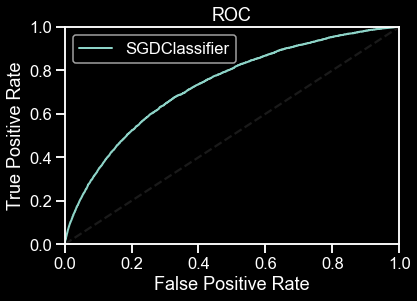

accuracy: 0.7849338232902995
roc_auc: 0.7332587998900844


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



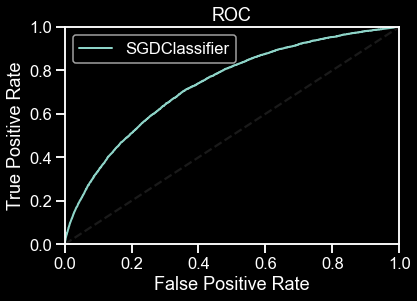

accuracy: 0.7570973301681246
roc_auc: 0.7295352733652609


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



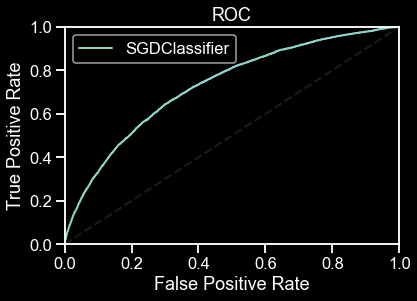

accuracy: 0.7845598517121395
roc_auc: 0.7395258540864816


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



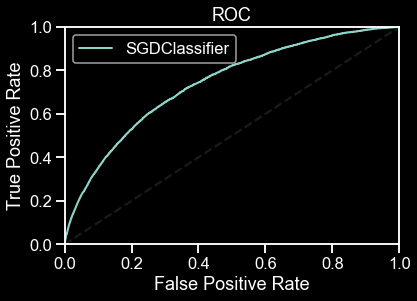

accuracy: 0.7775194302624305
roc_auc: 0.7364786930876714


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



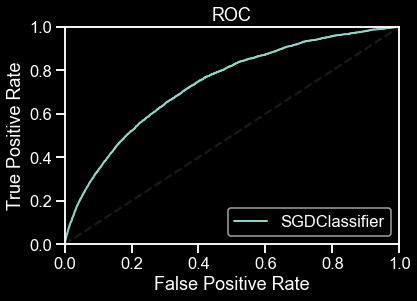

In [490]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
    clone_clf_sgd = clone(SGDClassifier(class_weight={0:0.10,1:0.90},early_stopping=True,random_state=42,loss='modified_huber',max_iter=10000))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_sgd.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_sgd.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_sgd.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"SGDClassifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [491]:
train_data_new_rescaled.shape

(307511, 236)

In [492]:
clone_clf_sgd.fit(train_data_new_rescaled,Y)

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 0.1, 1: 0.9},
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [493]:
clone_clf_sgd.predict_proba(test_data_new_rescaled)[:,1]

array([0.42374734, 0.75673541, 0.3607108 , ..., 0.38704314, 0.54446508,
       0.69017048])

In [494]:
submit['TARGET'] =clone_clf_sgd.predict_proba(test_data_new_rescaled)[:,1]

In [495]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_sgd-02.csv',index=False)

##### Cross-validation with ExtraTree

accuracy: 0.8155862315659399
roc_auc: 0.7269593190751904


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



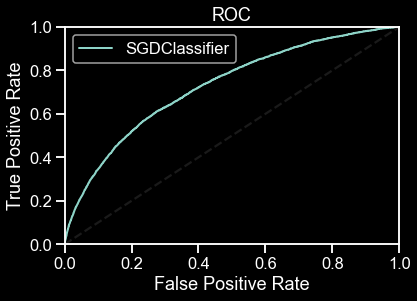

accuracy: 0.8107378621833436
roc_auc: 0.7306153492403206


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



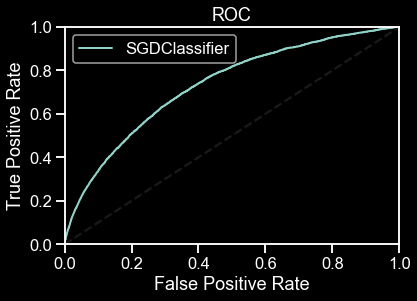

accuracy: 0.8134532210334623
roc_auc: 0.7229406382377618


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



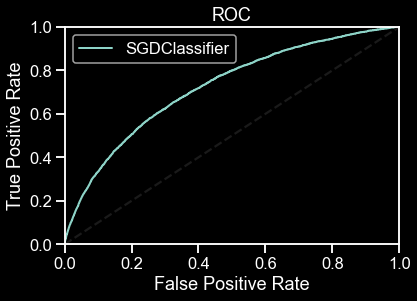

accuracy: 0.8171604175473969
roc_auc: 0.7283855125325783


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



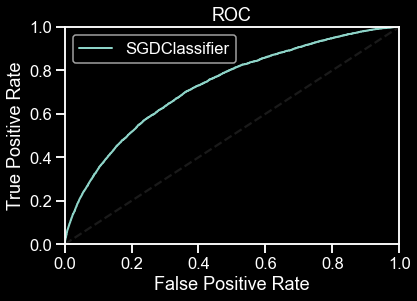

accuracy: 0.8137458944424572
roc_auc: 0.7302177947936705


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



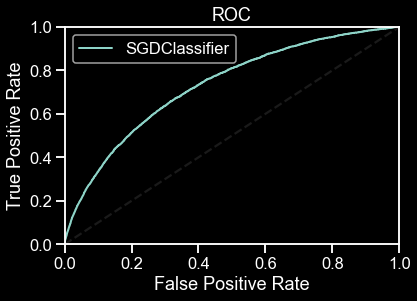

In [496]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
    clone_clf_ext = clone(ExtraTreesClassifier(n_estimators=300,max_depth=10,class_weight={0:0.10,1:0.90}))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_ext.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_ext.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_ext.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"SGDClassifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [497]:
clone_clf_ext.fit(train_data_new_rescaled,Y)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 0.1, 1: 0.9},
                     criterion='gini', max_depth=10, max_features='auto',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=300, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [498]:
clone_clf_ext.predict_proba(test_data_new_rescaled)[:,1]

array([0.37811137, 0.50974628, 0.3284127 , ..., 0.41243812, 0.36291325,
       0.51712814])

In [499]:
submit['TARGET'] =clone_clf_ext.predict_proba(test_data_new_rescaled)[:,1]

In [500]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_ext-02.csv',index=False)

#### AdaBoots LR

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

accuracy: 0.9192722306228964
roc_auc: 0.6802221870971504


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



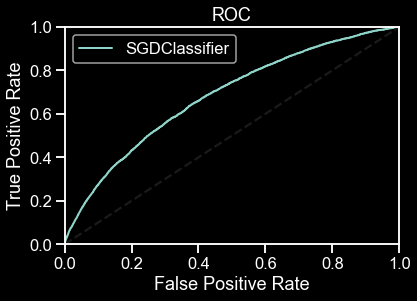

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

accuracy: 0.9192709180189262
roc_auc: 0.6875863467286019


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



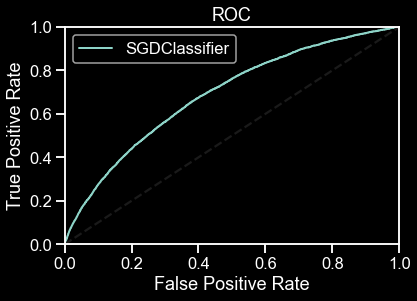

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

accuracy: 0.9192709180189262
roc_auc: 0.6792601324933305


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



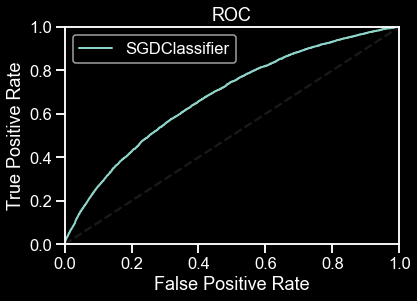

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

accuracy: 0.9192709180189262
roc_auc: 0.6823336199497264


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



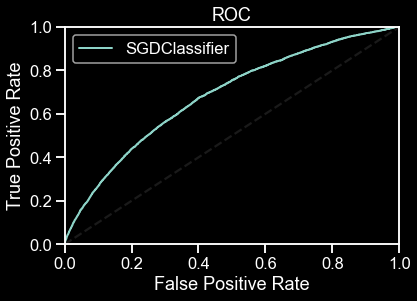

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

accuracy: 0.9192709180189262
roc_auc: 0.6815492482611847


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



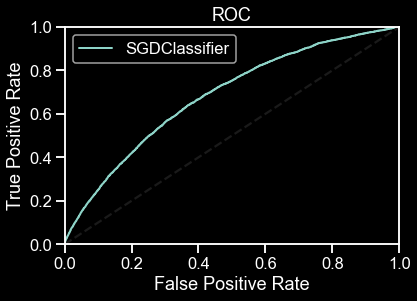

In [503]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
    clone_clf_ada = clone(AdaBoostClassifier(LogisticRegression(C=1.0,class_weight={0:0.10,1:0.90}),learning_rate=0.1))
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_ada.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_ada.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_ada.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"SGDClassifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [504]:
clone_clf_ada.fit(train_data_new_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0,
                                                     class_weight={0: 0.1,
                                                                   1: 0.9},
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='warn', tol=0.0001,
                                                     verbose=0,
                                 

In [505]:
submit['TARGET'] =clone_clf_ada.predict_proba(test_data_new_rescaled)[:,1]

In [506]:
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_ada_lr-02.csv',index=False)

##### AdaBoost RF

##### Cross validation MLPclassifier

accuracy: 0.917890184218656
roc_auc: 0.7270747722650297


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



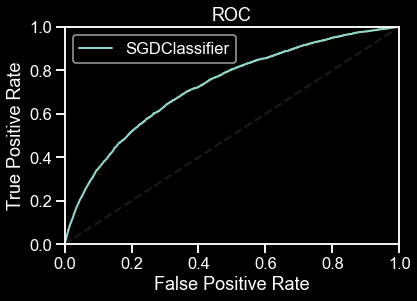

accuracy: 0.9181164840167799
roc_auc: 0.7317478927834888


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



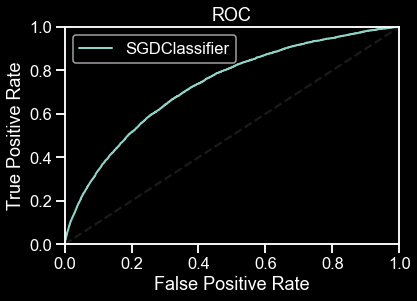

accuracy: 0.9177262528047868
roc_auc: 0.7177278856375833


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



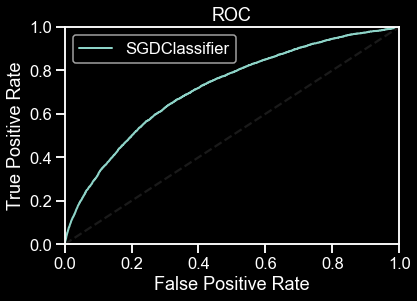

accuracy: 0.9183115996227765
roc_auc: 0.7297079200653938


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



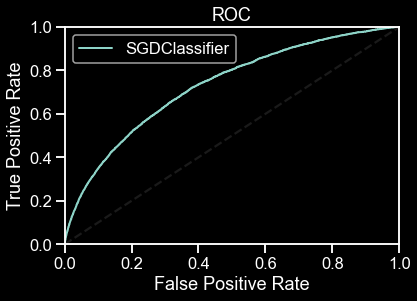

accuracy: 0.9161978472244805
roc_auc: 0.7275020942269517


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



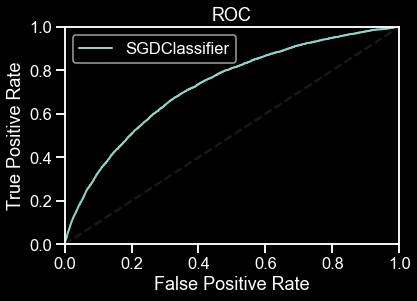

In [515]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(train_data_new_rescaled,Y):
    clone_clf_mlp = MLPClassifier(random_state=random_state,solver='adam', max_iter=800) 
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_mlp.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_mlp.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_mlp.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"SGDClassifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [521]:
clone_clf_mlp.fit(train_data_new_rescaled,Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=800, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=3, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [522]:
clone_clf_mlp.predict_proba(test_data_new_rescaled)[:,1]

array([0.0843002 , 0.33954576, 0.0039336 , ..., 0.01346048, 0.0083774 ,
       0.06334286])

In [523]:
submit['TARGET'] =clone_clf_mlp.predict_proba(test_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_mlp-02.csv',index=False)

In [654]:
gsXGB.fit(training_data_new_rescaled,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...a=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bylevel': [0.9], 'colsample_bytree': [0.8],
                         'gamma': [0.99], 'max_depth': [4],
                         'mi

In [655]:
submit['TARGET'] =gsXGB.predict_proba(testing_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_gsXGB-03.csv',index=False)

##### Let's do little more feature engg -> The columns which are highly correlated with sale price are generated by polynomial degree 2 & 3


In [626]:
training_data = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_train.csv')
testing_data = pd.read_csv('/Users/nandrajog/Downloads/home-credit-default-risk/application_test.csv')

In [627]:
def poly(df,cols):
    for col in cols:
        df[col+'_2degree'] = df[col]**2
        df[col+'_3degree'] = df[col]**3
        df[col +'_expo'] = df[col]**(1/1.2)

In [628]:
cols =['EXT_SOURCE_3','EXT_SOURCE_2']

In [629]:
binary_encoding(training_data)
binary_encoding(testing_data)

In [630]:
training_data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [631]:
poly(training_data,cols)
poly(testing_data,cols)

In [632]:
training_data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_3_2degree,EXT_SOURCE_3_3degree,EXT_SOURCE_3_expo,EXT_SOURCE_2_2degree,EXT_SOURCE_2_3degree,EXT_SOURCE_2_expo
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,0.019426,0.002707,0.193563,0.069142,0.018181,0.328518
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.387190,0.240927,0.673444
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.532268,0.388325,0.768931,0.309038,0.171798,0.613063
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.423074,0.275185,0.698780
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.104160,0.033616,0.389681


In [537]:
# training_data.EXT_SOURCE_3_2degree

In [633]:
import scipy.stats as stats
import pylab 

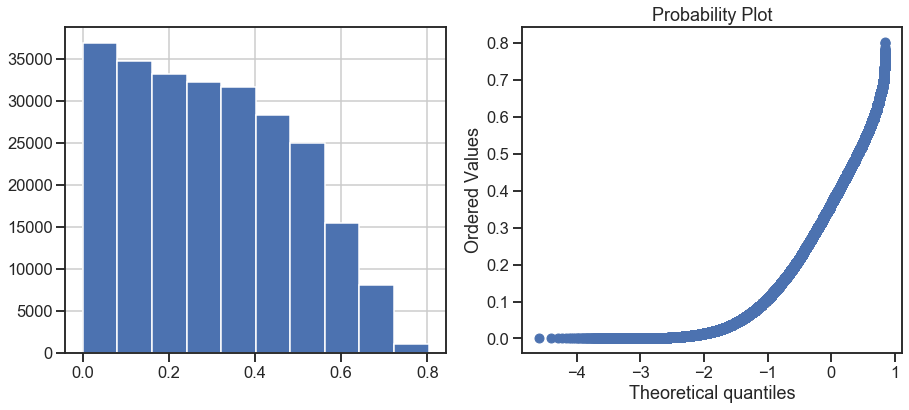

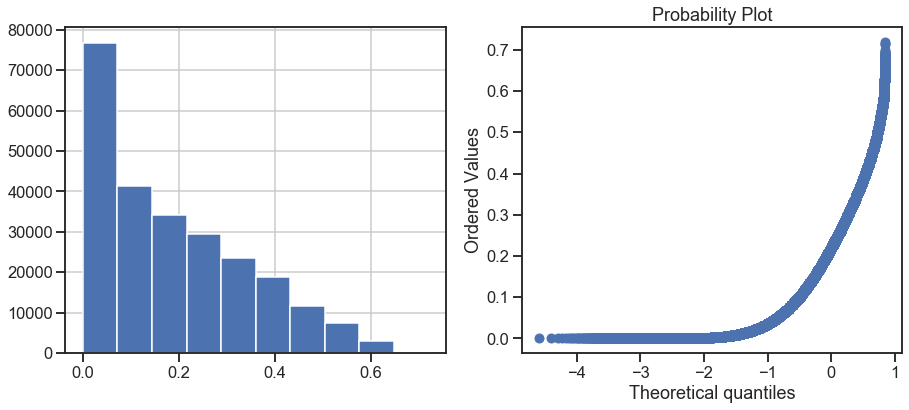

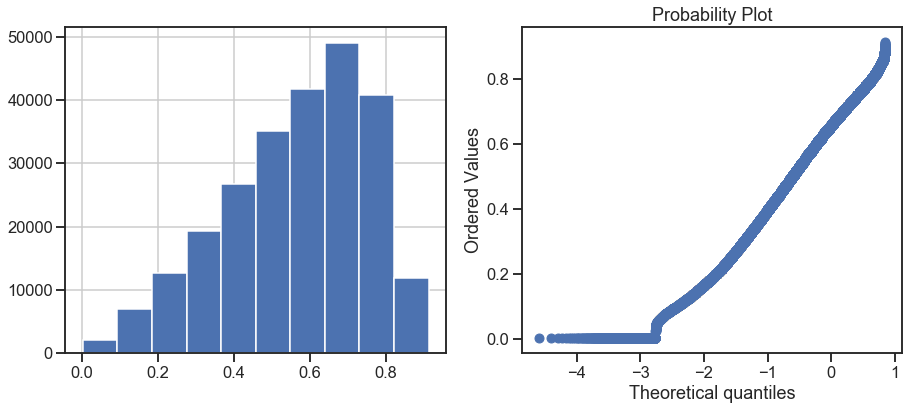

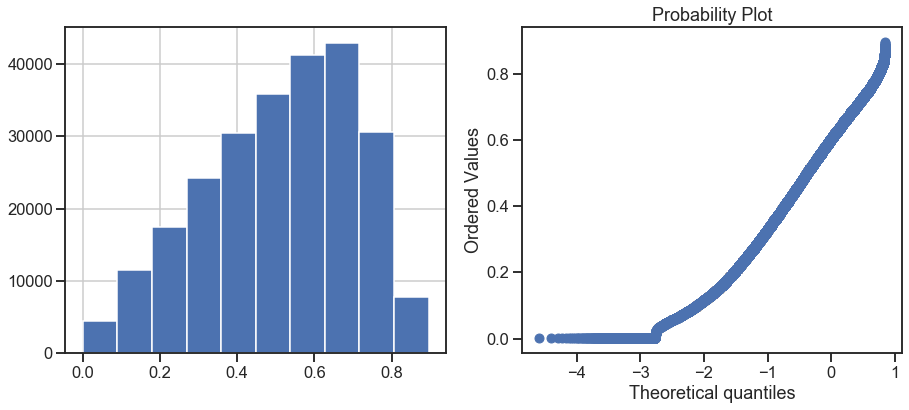

In [634]:
def diagnostic_plot(df,col):
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    df[col].hist()
    
    plt.subplot(1,2,2)
    stats.probplot(df[col], dist='norm', plot = pylab)
    plt.show()
diagnostic_plot(training_data,'EXT_SOURCE_3_2degree')
diagnostic_plot(training_data,'EXT_SOURCE_3_3degree')
diagnostic_plot(training_data,'EXT_SOURCE_3_expo')
diagnostic_plot(training_data,'EXT_SOURCE_3')


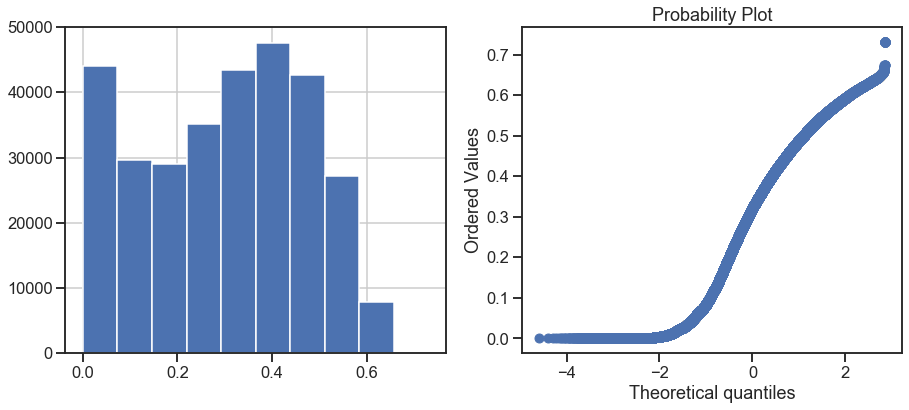

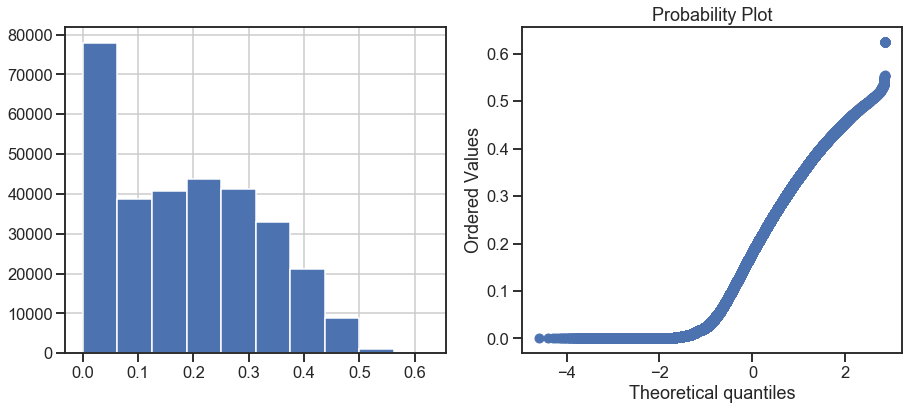

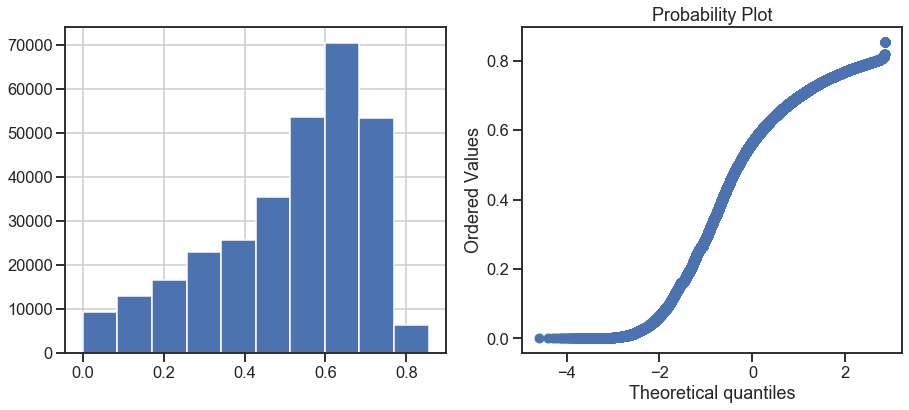

In [558]:
diagnostic_plot(training_data,'EXT_SOURCE_2_2degree')
diagnostic_plot(training_data,'EXT_SOURCE_2_3degree')
diagnostic_plot(training_data,'EXT_SOURCE_2')

In [635]:
training_data.drop(columns=['SK_ID_CURR','TARGET'],inplace =True)

In [564]:
# training_data_new = training_data.drop(columns=['EXT_SOURCE_3','EXT_SOURCE_2'])

In [636]:
testing_data.drop(columns='SK_ID_CURR',inplace=True)

In [637]:
training_data_new = pd.get_dummies(training_data)
testing_data_new = pd.get_dummies(testing_data)

In [638]:
Imputation_mean_new(training_data_new)
Imputation_mean_new(testing_data_new)

In [639]:
training_data_new.shape

(307511, 247)

In [640]:
testing_data_new.shape

(48744, 243)

In [641]:
training_data_new.isna().sum()

NAME_CONTRACT_TYPE                 0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
                                  ..
WALLSMATERIAL_MODE_Panel           0
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_No             0
EMERGENCYSTATE_MODE_Yes            0
Length: 247, dtype: int64

In [642]:
training_data_new

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,...,0,1,0,0,0,0,0,0,1,0
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,...,0,0,0,0,0,0,1,0,1,0
307507,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,...,0,0,0,0,0,0,1,0,1,0
307508,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,...,0,0,0,0,0,1,0,0,1,0
307509,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,...,0,0,0,0,0,0,1,0,1,0


In [643]:
training_data_new, testing_data_new = training_data_new.align(testing_data_new,join='inner',axis=1)

In [577]:
# training_data_new.EXT_SOURCE_2_3degree

In [644]:
training_data_new_rescaled = min_scaler.fit_transform(training_data_new)
testing_data_new_rescaled = min_scaler.fit_transform(testing_data_new)

##### LogisticRegression

In [645]:
clone_clf_lr.fit(training_data_new_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [646]:
clone_clf_lr.predict_proba(testing_data_new_rescaled)[:,1]

array([0.34440701, 0.72450108, 0.34433331, ..., 0.32532756, 0.32434143,
       0.60397584])

In [648]:
submit['TARGET'] =clone_clf_lr.predict_proba(testing_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_lr_3-03.csv',index=False)

##### SGD

In [649]:
clone_clf_sgd.fit(training_data_new_rescaled,Y)

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 0.1, 1: 0.9},
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [650]:
clone_clf_sgd.predict_proba(testing_data_new_rescaled)[:,1]

array([0.44484907, 0.74559003, 0.35914061, ..., 0.39079168, 0.54259865,
       0.69719724])

In [651]:
submit['TARGET'] =clone_clf_sgd.predict_proba(testing_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_sgd-03.csv',index=False)

#### RandomForest

In [656]:
clone_clf_rf.fit(training_data_new_rescaled,Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [657]:
submit['TARGET'] =clone_clf_rf.predict_proba(testing_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_rf-03.csv',index=False)

###### Cross validation VOTING CLASSIFIER

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7895387216883729
roc_auc: 0.7408721890190548


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



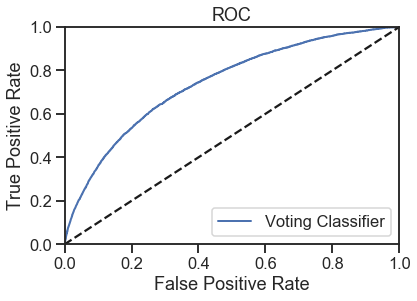

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7826574745536731
roc_auc: 0.7423612741300109


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



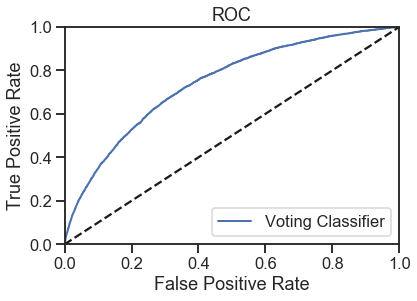

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7744951383694839
roc_auc: 0.737603442004426


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



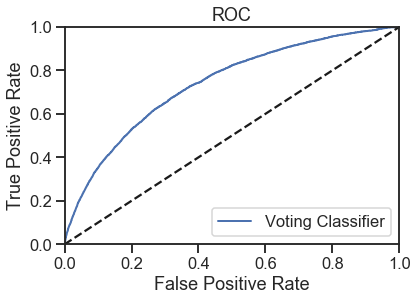

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7853403141361257
roc_auc: 0.7447896778769105


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



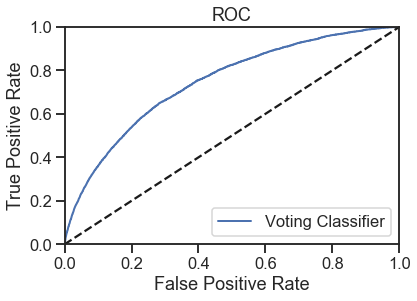

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



accuracy: 0.7824298396800105
roc_auc: 0.744812028647532


/anaconda3/envs/C-vision/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



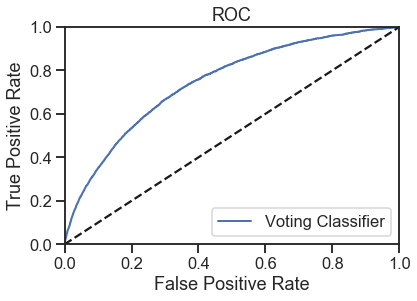

In [661]:
skfolds = StratifiedKFold(n_splits=5,random_state=42)

# new_train_rescaled = min_scaler.fit_transform(new_train)

for train_index, test_index in skfolds.split(training_data_new_rescaled,Y):
    clone_clf_VO = VotingClassifier(estimators=[('lr',clone_clf_lr),('SGD',clone_clf_sgd),('RF',clone_clf_rf)],
                                    voting='soft') 
    X_train_folds = new_train_rescaled[train_index]
    Y_train_folds = (Y[train_index])
    X_test_folds = new_train_rescaled[test_index]
    Y_test_folds = (Y[test_index])
    
    clone_clf_VO.fit(X_train_folds,Y_train_folds)
    y_pred_prob = clone_clf_VO.predict_proba(X_test_folds)[:,1]
    y_pred = clone_clf_VO.predict(X_test_folds)
    n_correct = sum(y_pred == Y_test_folds)
    print("accuracy:",(n_correct/len(y_pred)))
    print("roc_auc:", (roc_auc_score(Y_test_folds,y_pred_prob)))
    fpr_sgd, tpr_sgd, threshold = roc_curve(Y_test_folds,y_pred_prob)
    plot_roc_curve(fpr_sgd,tpr_sgd,"Voting Classifier")
    plt.legend(loc='bottom right')
    plt.title('ROC')
    plt.show()

In [662]:
clone_clf_VO.fit(training_data_new_rescaled,Y)

/anaconda3/envs/C-vision/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0,
                                                 class_weight={0: 0.1, 1: 0.9},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('SGD',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight={0: 0.1, 1:...
                                                

In [664]:
submit['TARGET'] =clone_clf_VO.predict_proba(testing_data_new_rescaled)[:,1]
submit.to_csv('/Users/nandrajog/Desktop/clone_clf_voting-03.csv',index=False)

##### We tried various combination of classifiers to boot our prediction such as voting classifier with (Logistic regression,SGDClassifier, Random Forest) as an estimator, XGBoost, ExtraTree classifier, MLPClassifer, but the best possible results are generated by Logistic regression i.e 0.73490